In [1]:
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.features import geometry_mask

In [21]:
# set tif to process
dem_tile = '19TDJ412852.tif'

In [22]:
#load coastline file and retrieve coordinate system
coastline = gpd.read_file('WolfNeckFinal.kml')
print(f"Coast CRS: {coastline.crs}")

Coast CRS: EPSG:4326


In [23]:
# retrieve DEM CRS
with rasterio.open(dem_tile) as src:
    dem_crs = src.crs
    print(f"DEM CRS: {dem_crs}")

DEM CRS: EPSG:6348


In [24]:
# reproject coastline to match DEM
coastline = coastline.to_crs(dem_crs)
print(f"Reprojected CRS: {coastline.crs}")

Reprojected CRS: PROJCS["NAD83(2011) / UTM zone 19N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6348"]]


In [27]:
# Create a mask for ocean areas
with rasterio.open(dem_tile) as src:
    dem_data = src.read(1)
    transform = src.transform

    # rasterize the coast polygon
    # mask=True means ocean True, land False
    ocean_mask = geometry_mask(
            coastline.geometry,
            out_shape=dem_data.shape,
            transform=transform, # from src above
            invert=True # true where polygon exists (ocean)
    )

# set ocean cells to very low (and uniform) elevation
# will enforce pit creation precisely at boundary
# and no source/sink/node creation in ocean
dem_data[ocean_mask] = - 10.0

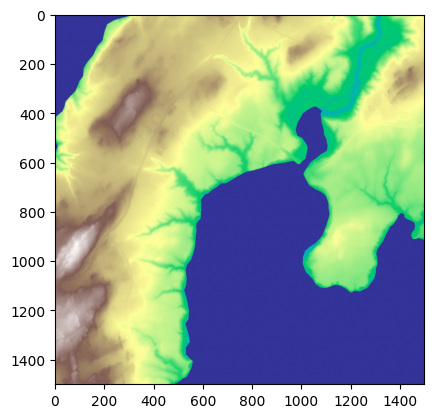

In [28]:
plt.imshow(dem_data, cmap='terrain', alpha=1)

In [13]:
print(dem_data[1000,1000])

-10.0


mask true pixels: 0
mask false pixels: -1


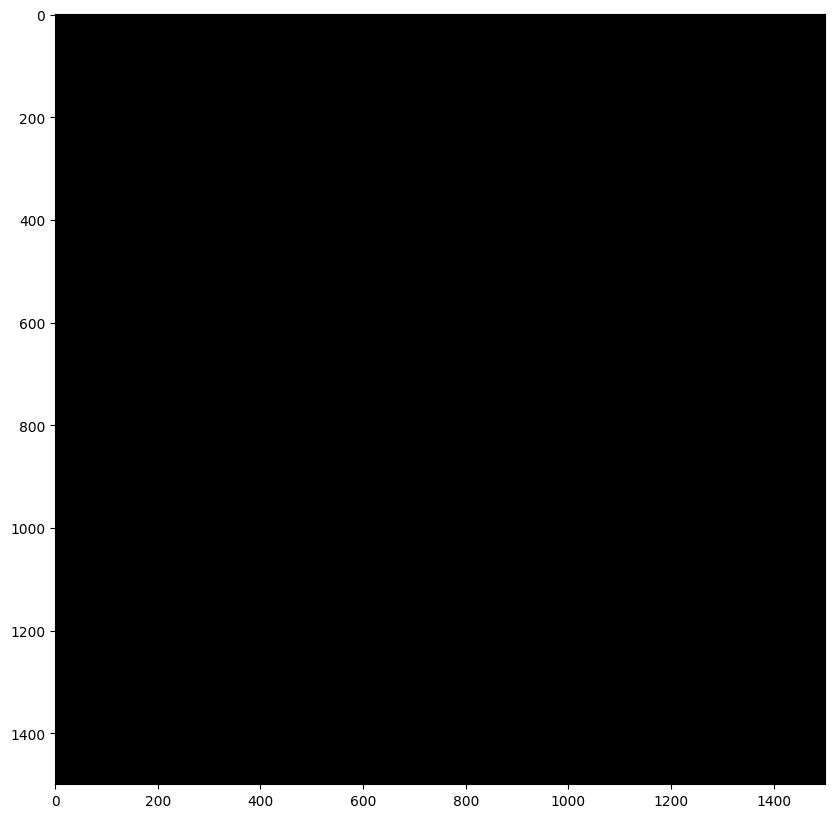

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(ocean_mask, cmap='gray')

print(f'mask true pixels: {ocean_mask.sum()}')
print(f'mask false pixels: {~ocean_mask.sum()}')

In [17]:
print(coastline.geometry.iloc[0].geom_type)
print(coastline.crs)

Polygon
EPSG:4326


In [18]:
geom = coastline.geometry.iloc[0]
print(f"Geometry type: {geom.geom_type}")
print(f"Has holes: {len(geom.interiors) if hasattr(geom, 'interiors') else 'N/A'}")

Geometry type: Polygon
Has holes: 0


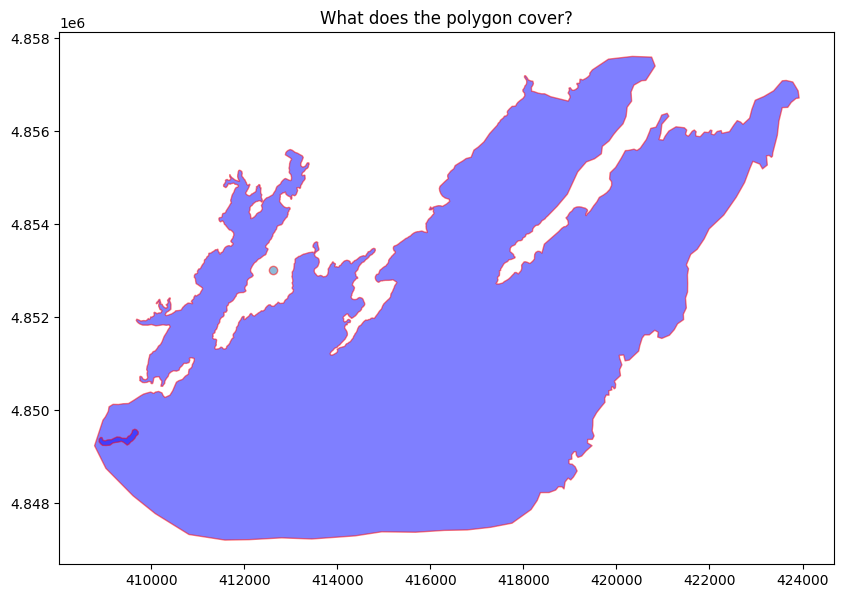

In [26]:
# Plot it to see what it actually covers
fig, ax = plt.subplots(figsize=(10, 10))
coastline.plot(ax=ax, facecolor='blue', edgecolor='red', alpha=0.5)
ax.set_title("What does the polygon cover?")
plt.show()